In [41]:
import json
import pandas as pd
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)


with open('backtest_result.json') as f:
    data = json.load(f)

daily_return = {}
temp = pd.read_json(data['ETHUSDT'])

for item in temp['datetime']:
    daily_return[item] = 0
    
for symbol in data.keys():    
    df = pd.read_json(data[symbol])
    try:
        target = df[df['signal'] == -1]
    except:
        pass
    if len(target) >= 1:
        for i in range(len(target)):
            daily_return[target.iloc[i]['datetime']] += target.iloc[i]['strategy_return']
    
print(daily_return)

{Timestamp('2019-12-31 16:00:00'): 0, Timestamp('2019-12-31 17:00:00'): 0, Timestamp('2019-12-31 18:00:00'): 0, Timestamp('2019-12-31 19:00:00'): 0, Timestamp('2019-12-31 20:00:00'): 0, Timestamp('2019-12-31 21:00:00'): 0, Timestamp('2019-12-31 22:00:00'): 0, Timestamp('2019-12-31 23:00:00'): 0, Timestamp('2020-01-01 00:00:00'): 0, Timestamp('2020-01-01 01:00:00'): 0, Timestamp('2020-01-01 02:00:00'): 0, Timestamp('2020-01-01 03:00:00'): 0, Timestamp('2020-01-01 04:00:00'): 0, Timestamp('2020-01-01 05:00:00'): 0, Timestamp('2020-01-01 06:00:00'): 0, Timestamp('2020-01-01 07:00:00'): 0, Timestamp('2020-01-01 08:00:00'): 0, Timestamp('2020-01-01 09:00:00'): 0, Timestamp('2020-01-01 10:00:00'): 0, Timestamp('2020-01-01 11:00:00'): 0, Timestamp('2020-01-01 12:00:00'): 0, Timestamp('2020-01-01 13:00:00'): 0, Timestamp('2020-01-01 14:00:00'): 0, Timestamp('2020-01-01 15:00:00'): 0, Timestamp('2020-01-01 16:00:00'): 0, Timestamp('2020-01-01 17:00:00'): 0, Timestamp('2020-01-01 18:00:00'): 0, 

In [42]:
# draw analysis plot of daily_return
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

accumulated_return = {}
for key in daily_return.keys():
    if key == list(daily_return.keys())[0]:
        accumulated_return[key] = daily_return[key]
    else:
        accumulated_return[key] = accumulated_return[list(accumulated_return.keys())[-1]] + daily_return[key]



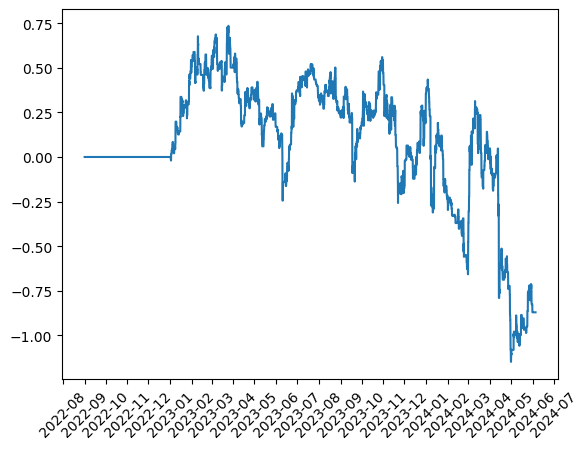

Total return:  -0.8716829635000005
Total return rate:  -8.716829635000006e-05
Max drawdown:  1.8855935999999995
Max drawdown start:  2023-03-24 22:00:00
Max drawdown end:  2024-05-01 00:00:00


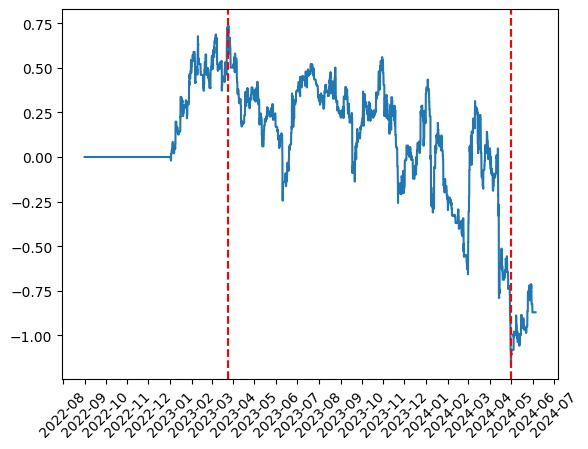

In [43]:
# from 2022-01-01
start = datetime.datetime(2022, 9, 1)
accumulated_return = {k: v for k, v in accumulated_return.items() if k >= start}

fig, ax = plt.subplots()
ax.plot(accumulated_return.keys(), accumulated_return.values())
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.show()


# calculate the total return
total_return = 0
for key in daily_return.keys():
    total_return += daily_return[key]
print('Total return: ', total_return)
print('Total return rate: ', total_return/10000)

# calculate the max drawdown
max_drawdown = 0
max_drawdown_start = None
max_drawdown_end = None
current_max = 0
current_max_date = None
for key in accumulated_return.keys():
    if accumulated_return[key] > current_max:
        current_max = accumulated_return[key]
        current_max_date = key
    if current_max - accumulated_return[key] > max_drawdown:
        max_drawdown = current_max - accumulated_return[key]
        max_drawdown_start = current_max_date
        max_drawdown_end = key
print('Max drawdown: ', max_drawdown)
print('Max drawdown start: ', max_drawdown_start)
print('Max drawdown end: ', max_drawdown_end)

# draw the max drawdown plot
fig, ax = plt.subplots()
ax.plot(accumulated_return.keys(), accumulated_return.values())
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.axvline(x=max_drawdown_start, color='r', linestyle='--')
plt.axvline(x=max_drawdown_end, color='r', linestyle='--')
plt.show()

